In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

In [2]:
def find_cointegrated_pairs(data):
    pairs={}
    n=close_df.shape[1]
    matrix=np.ones((n,n))
    keys= data.keys()
    for i in range(n):
        for j in range(i+1,n):
            result= coint(close_df[keys[i]],close_df[keys[j]])
            matrix[i][j]=result[1]
            if matrix[i][j] <0.05:
                pairs[(keys[i],keys[j])]=matrix[i][j]
    return pairs,matrix
def correlated_pairs(data):
    pairs={}
    n=corr_matrix.shape[1]
    keys = data.keys()
    for i in range(n):
        for j in range(i+1,n):
            if data.iloc[i,j]>0.3:
                pairs[(keys[i],keys[j])] = data.iloc[i,j]
    return pairs

In [3]:
tickers = ["APOLLOHOSP.NS","DRREDDY.NS","SUNPHARMA.NS","CIPLA.NS","GLENMARK.NS","FORTIS.NS","DIVISLAB.NS","PFIZER.NS","LUPIN.NS","AUROPHARMA.NS"]
ohlcv={}
return_df = pd.DataFrame()
close_df=pd.DataFrame()
ohlcv_train ={}
ohlcv_test={}
for ticker in tickers:
    ohlcv[ticker]= yf.download(ticker,period="10y",interval="1d")
    ohlcv[ticker].dropna(how="any",inplace=True)
    ohlcv[ticker]["returns"]= ohlcv[ticker]["Adj Close"].pct_change()
    ohlcv[ticker].dropna(how="any",inplace=True)
    mid = round(len(ohlcv[ticker])/2)
    #ohlcv_train[ticker], ohlcv_test[ticker] = train_test_split(ohlcv[ticker], test_size=0.5, shuffle=False)
    
    ohlcv_train[ticker]= ohlcv[ticker].iloc[:mid]
    ohlcv_test[ticker]= ohlcv[ticker].iloc[mid:]
    close_df[ticker]= ohlcv_train[ticker]["Adj Close"]
    close_df.dropna(axis=1,how="any",inplace=True)
    return_df[ticker]= ohlcv_train[ticker]["returns"]
    return_df.dropna(axis=1,how="any",inplace=True)
    

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


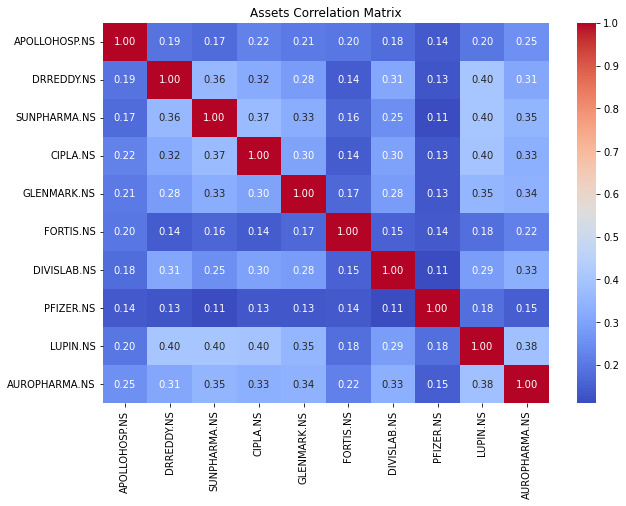

In [4]:
corr_matrix = pd.DataFrame()
coint_matrx= pd.DataFrame()
corr_matrix = return_df.corr()
stock_pairs_coint={}
stock_pairs_corr={}
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
ax.set_title('Assets Correlation Matrix')
plt.show()

In [5]:
stock_pairs_coint,coint_matrix = find_cointegrated_pairs(close_df)
stock_pairs_corr =correlated_pairs(corr_matrix)

def find_stocks_1(d1,d2):
    list1=[]
    d1_keys= list(d1.keys())
    d2_keys= list(d2.keys())
    for i in range(len(d1_keys)):
        for j in range(len(d2_keys)):
            if d1_keys[i]==d2_keys[j]:
                list1.append(d1_keys[i])
    return list1

In [6]:
list_of_stocks_1 = find_stocks_1(stock_pairs_corr,stock_pairs_coint)

'''def find_stocks_2(D,L):
    min1=0
    keys = list(D.keys())
    for i in range(len(keys)):
        if keys[i] in L:
            min1'''

def find_optimal_stock():
    min1=1000
    t=()
    for i in range(len(list_of_stocks_1)):
        if(stock_pairs_coint[list_of_stocks_1[i]]<min1):
            t= list_of_stocks_1[i]
            min1 = stock_pairs_coint[list_of_stocks_1[i]]
    return t

final_stocks = find_optimal_stock()
stock_1,stock_2 = final_stocks[0],final_stocks[1]
print(stock_1)
print(stock_2)
close_df['spread'] = close_df[stock_1] - close_df[stock_2]
mean_spread = close_df['spread'].mean()

DRREDDY.NS
LUPIN.NS


In [7]:
# implementation of strategy using z score 
# The stragegy is based on mean reversion of cointegrated stocks.
# when the spread between the stocks crosses a particular z score cutoff, the code buys under performing stock
# and sells over performing stock.
# the code has two parameters z score cutoff and lookback days for rolling average of spread which can be adjusted
# to get maximum returns.

In [8]:
lookback = 50
zscore_cutoff = 0.7

In [9]:
df = pd.DataFrame()

df[stock_1] = close_df[stock_1]
df[stock_2] = close_df[stock_2]

Text(0.5, 1.0, 'prices vs time')

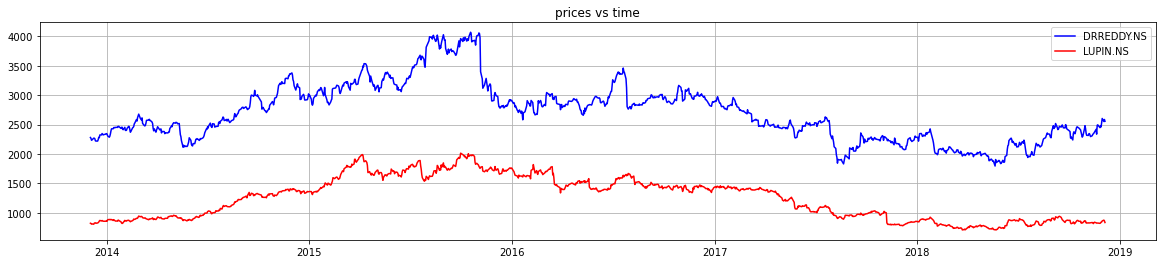

In [10]:
plt.figure(figsize = (20,4))
plt.plot(df[stock_1], color = 'blue', label=stock_1)
plt.plot(df[stock_2], color = 'red', label=stock_2)
plt.grid(True)
plt.legend()
plt.title('prices vs time')

In [11]:

df['Spread'] = df[stock_1] - df[stock_2]
df['Spread_ema'] = df['Spread'].ewm(span = lookback, adjust = False).mean()
df['Spread_wrt_ema'] = df['Spread_ema'] - df['Spread']

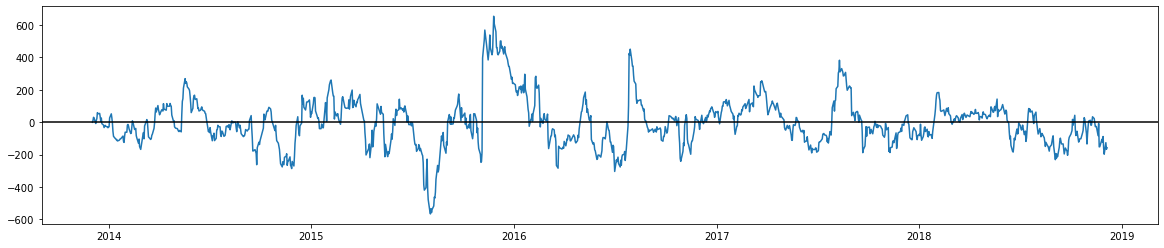

In [12]:
plt.figure(figsize=(20,4))
plt.plot(df['Spread_wrt_ema'])
plt.axhline(0,color= 'black')

In [13]:
df['zscore'] = df['Spread_wrt_ema']/df['Spread'].std()


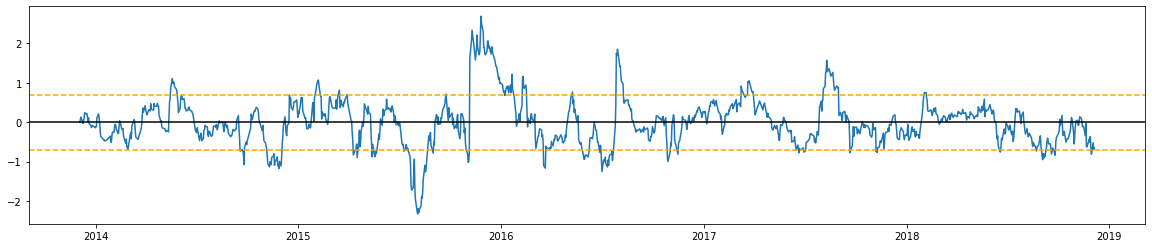

In [14]:
plt.figure(figsize=(20,4))
plt.plot(df['zscore'])
# plt.axhline(1,color='red', linestyle='--')
plt.axhline(0,color='black')
# plt.axhline(-1,color='red', linestyle='--')
# plt.axhline(0.5,color = 'pink',linestyle='--')
# plt.axhline(-0.5,color ='pink',linestyle='--')
plt.axhline(zscore_cutoff,color='orange',linestyle='--')
plt.axhline(-zscore_cutoff,color='orange',linestyle='--')

In [15]:
position = 0
for index, row in df.iterrows():
    if df.at[index, 'zscore'] > zscore_cutoff and position == 0:
        df.at[index,'pos'] = 1
        position = 1
    elif df.at[index, 'zscore'] < 0 and position == 1:
        df.at[index,'pos'] = 0
        position = 0
    else:
        df.at[index,'pos'] = np.nan
    

In [16]:
long_trades = pd.DataFrame()
long_trades['buy'] = df.loc[df['pos'] ==1, stock_2].copy().reset_index().drop('Date', axis = 1)
long_trades['sell'] = df.loc[df['pos'] ==1, stock_1].copy().reset_index().drop('Date', axis = 1)
long_trades['sq_off_buy'] = df.loc[df['pos'] ==0, stock_2].copy().reset_index().drop('Date', axis = 1)
long_trades['sq_off_sell'] = df.loc[df['pos'] ==0, stock_1].copy().reset_index().drop('Date', axis = 1)
long_trades['profit/loss'] = (long_trades['buy'] - long_trades['sq_off_buy']) * (long_trades['sell'] / long_trades['buy']) + (long_trades['sq_off_sell'] - long_trades['sell'])

In [17]:
long_trades.dropna(inplace = True)
long_trades

,buy,sell,sq_off_buy,sq_off_sell,profit/loss
0,909.242615,2225.397705,994.035217,2426.173096,-6.756967
1,1478.650269,2922.228271,1568.242432,3155.607910,56.320359
2,1773.343506,3084.113770,1980.252197,3495.996094,52.036676
3,1900.534546,3715.869385,1979.837036,3974.419678,103.500391
4,1774.013794,3398.028320,1633.551636,2906.431641,-222.548946
5,1819.656738,2769.973633,1696.573486,2904.747070,322.136996
6,1532.955688,2658.083008,1436.895142,2839.419678,347.901763
7,1649.081421,2804.888428,1419.328247,2872.605469,458.499455
8,1394.007935,2545.735840,1213.169189,2442.912842,227.424530
9,958.487122,2123.519775,967.610474,2194.776611,51.044130


In [18]:
sum(long_trades['profit/loss'])

1561.6718016715893

In [19]:
position = 0
for index, row in df.iterrows():
    if df.at[index, 'zscore'] < -zscore_cutoff and position == 0:
        df.at[index,'spos'] = 1
        position = 1
    elif df.at[index, 'zscore'] > 0 and position == 1:
        df.at[index,'spos'] = 0
        position = 0
    else:
        df.at[index,'spos'] = np.nan
    

In [20]:
short_trades = pd.DataFrame()
short_trades['buy'] = df.loc[df['spos'] == 1, stock_1].copy().reset_index().drop('Date',axis = 1)
short_trades['sell'] = df.loc[df['spos'] == 1, stock_2].copy().reset_index().drop('Date',axis = 1)
short_trades['sq_off_buy'] = df.loc[df['spos'] == 0, stock_1].copy().reset_index().drop('Date',axis = 1)
short_trades['sq_off_sell'] = df.loc[df['spos'] == 0, stock_2].copy().reset_index().drop('Date',axis = 1)
short_trades['profit/loss'] = (short_trades['buy'] - short_trades['sq_off_buy']) + (short_trades['sq_off_sell'] - short_trades['sell']) * (short_trades['buy']/short_trades['sell'])

In [21]:
short_trades.dropna(inplace = True)
short_trades

,buy,sell,sq_off_buy,sq_off_sell,profit/loss
0,2972.171387,1310.118164,2761.273682,1266.130371,111.105745
1,3162.449951,1349.921021,3086.347656,1385.063843,158.431124
2,3535.047852,1868.119141,3151.697754,1638.860474,-50.476814
3,3276.254150,1552.121460,3291.009277,1743.574585,389.368591
4,3510.199219,1779.620728,3793.177490,1775.684814,-290.741633
5,4021.028564,1813.879761,3398.028320,1774.013794,534.624931
6,2968.109619,1484.257080,2818.829102,1545.989624,272.728780
7,2916.399902,1413.309814,2810.545898,1397.936279,74.130332
8,3038.584961,1412.402954,3124.369873,1630.330933,383.056275
9,3129.216553,1419.807617,2923.899414,1456.493652,286.172141


In [22]:
sum(short_trades['profit/loss'])

2425.8927697090176

In [23]:
profits = sum(short_trades['profit/loss']) + sum(long_trades['profit/loss'])

In [24]:
cagr = ((2 * (df[stock_1].mean() + profits)) / (2 * df[stock_1].mean())) ** (1/5) -1

In [25]:
100* cagr

19.901023442917733